<a href="https://colab.research.google.com/github/DPasqua99/Dog_breed_prediction/blob/main/Dog_breed_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Prediction

In [1]:
#run this cell and upload the kaggle token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pasqua99","key":"f8cec953020d0d3ab46fc39b4c686a1b"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#permission changes to avoid a warning on the kaggle startup
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


To store the data we will create a new directory and make this a current work directory

In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           6625          9  0.1764706        


In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
100% 688M/691M [00:09<00:00, 66.3MB/s]
100% 691M/691M [00:09<00:00, 78.2MB/s]
/content


Now we will unzip the file we have downloaded and remove the irrelevant files

In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Output streaming troncato alle ultime 5000 righe.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91ba

Now import the required libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [9]:
labels_all = pd.read_csv('dog_dataset/labels.csv')
labels_all.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
#visualize the number of each breed
breeds_all = labels_all['breed'].value_counts()
breeds_all.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [11]:
#select the first 3 breed
CLASS_NAMES = ['maltese_dog', 'afghan_hound', 'scottish_deerhound']
labels = labels_all[labels_all['breed'].isin(CLASS_NAMES)]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


As we are working with the classification dataset first we need to one hot encode the target value i.e. the classes. After that we will read images and convert them into numpy array and finally normalizing the array.

In [12]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 359/359 [00:00<00:00, 440.78it/s]


Train Images shape:  (359, 224, 224, 3)  size: 54,039,552
One-hot encoded output shape:  (359, 3)  size: 1,077


Next we will create a network architecture for the model.

In [13]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 16)          │          25,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 8)           │           3,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,619 (635.23 KB)

 Trainable params: 162,619 (635.23 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [15]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3687 - loss: 4.9002 - val_accuracy: 0.3077 - val_loss: 4.8789
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.3580 - loss: 4.8680 - val_accuracy: 0.3231 - val_loss: 4.8470
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.3901 - loss: 4.8379 - val_accuracy: 0.2769 - val_loss: 4.8181
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3327 - loss: 4.8121 - val_accuracy: 0.2923 - val_loss: 4.7914
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3395 - loss: 4.7861 - val_accuracy: 0.2769 - val_loss: 4.7659
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3258 - loss: 4.7590 - val_accuracy: 0.2923 - val_loss: 4.7406
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3209 - loss: 4.7335 - val_accuracy: 0.2923 - val_loss: 4.7151
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3405 - loss: 4.7059 - val_accuracy: 0.2923 - va

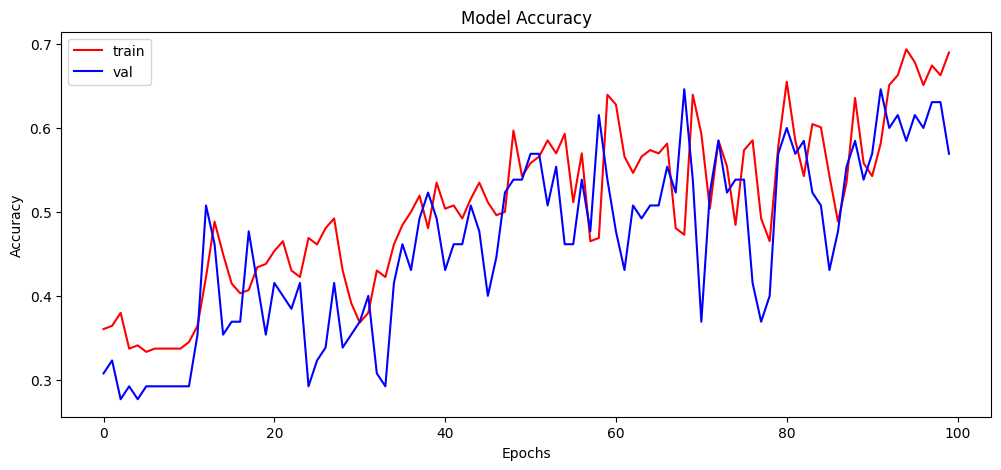

In [16]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

We will use predict function to make predictions using this model also we are finding out the accuracy on the test set.

In [17]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.6076 - loss: 3.0586
Accuracy over the test set: 
  58.33 %


Here you can see an example of an image with its original and predicted label.

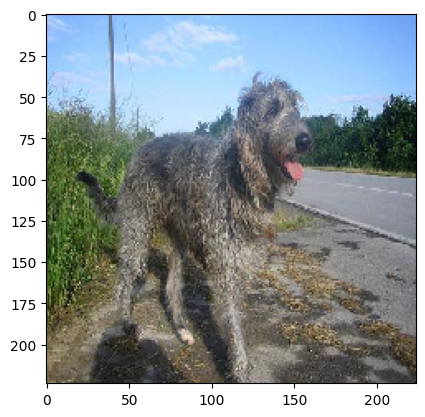

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [22]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])